# Import all important libraries like keras,LSTM,numpy,matplotlib

In [71]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
#tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

# Read the input.text file and convert all characters to lower case

In [72]:
path = 'train.5k.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 609718


# Preprocessing the data

# Found all unique chars in the corpus and create char to index and index to char maps

In [73]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print(f'unique chars: {len(chars)}')

unique chars: 48


# Cut the corpus into chunks of 40 characters, spacing the sequences by 3 characters

In [74]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 203226


# Create features and label for the model

In [75]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [76]:
#print(X.shape)
#print(y.shape)

(203226, 40, 48)
(203226, 48)


# Create LSTM model with 128 neurons

In [77]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

# Training the model using the following steps:
### Learing Rate : 1e-3
### Optimizer : Adams Optimizer
### Batch Size = 50
### Window Size = 20

In [80]:
import keras
from keras import optimizers
optimizer = keras.optimizers.Adam(learning_rate = 1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=50, epochs=20, shuffle=True).history

Train on 193064 samples, validate on 10162 samples
Epoch 1/20
193064/193064 [==============================] - 218s 1ms/step - loss: 2.2350 - accuracy: 0.3506 - val_loss: 1.9997 - val_accuracy: 0.4075
Epoch 2/20
193064/193064 [==============================] - 216s 1ms/step - loss: 1.9024 - accuracy: 0.4355 - val_loss: 1.8614 - val_accuracy: 0.4500
Epoch 3/20
193064/193064 [==============================] - 217s 1ms/step - loss: 1.7727 - accuracy: 0.4725 - val_loss: 1.7749 - val_accuracy: 0.4751
Epoch 4/20
193064/193064 [==============================] - 212s 1ms/step - loss: 1.6782 - accuracy: 0.4996 - val_loss: 1.7040 - val_accuracy: 0.4959
Epoch 5/20
193064/193064 [==============================] - 231s 1ms/step - loss: 1.6049 - accuracy: 0.5212 - val_loss: 1.6530 - val_accuracy: 0.5111
Epoch 6/20
193064/193064 [==============================] - 199s 1ms/step - loss: 1.5470 - accuracy: 0.5379 - val_loss: 1.6131 - val_accuracy: 0.5234
Epoch 7/20
193064/193064 [=======================

# Since the model takes alot of time to train, saving the model

In [85]:
model.save('keras_model.h5')
pickle.dump(history, open("history.p", "wb"))

# Reload the saved model 

In [86]:
model = load_model('keras_model.h5')
history = pickle.load(open("history.p", "rb"))

# Plotting model Accuracy

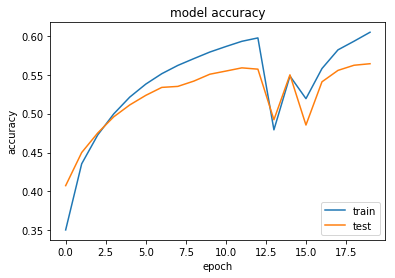

In [110]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right');

# Plotting Model Loss

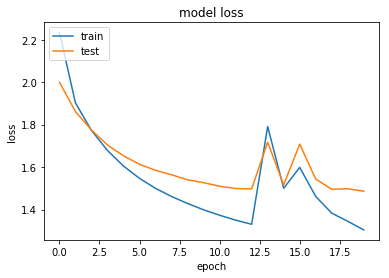

In [91]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Calculating the Perplexity

In [120]:
perplexity = np.exp(history['val_accuracy'])
perplexity

array([1.50305325, 1.56832764, 1.60818034, 1.64192109, 1.6671571 ,
       1.687791  , 1.70515294, 1.70733563, 1.71896796, 1.73425967,
       1.74127092, 1.74848256, 1.74555993, 1.63579273, 1.7328949 ,
       1.6247233 , 1.7174462 , 1.74281368, 1.75434241, 1.75779851])

# Testing the Model 

In [83]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.  
    return x

In [92]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

# Predict function

In [93]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [94]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

# Preprocess the input.text  file for making predictions

In [122]:
path = 'input.txt'
text1 = open(path).read().lower()
text2 = text1.replace('___',"").split("\n")
text3 = text2[:30]
#text3

# Predictions of the next word using RNN

In [121]:
for q in text3:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

but while the new york stock exchange di
['sconts ', 'rector ', 'vidend ', 'd ', 'fferent ']

some circuit breakers installed after th
['e ', 'ink ', 'an ', 'ree ', 'ough ']

the n stock specialist firms on the big 
['bond ', 'do ', 'political ', 'to ', 'some ']

big investment banks refused to step up 
['the ', 'n ', 'a ', '\n ', 'was ']

heavy selling of standard & poor 's 500-
['share ', 'discress ', 'whone ', 'fircal ', 'beard ']

seven big board stocks ual amr bankameri
['ng ', 'th ', 'lity ', 'al ', 'ca ']

once again the specialists were not able
[' to ', 'as ', 'tter ', 'ed ', 'st ']

<unk> james <unk> chairman of specialist
['s ', ' and ', 'ing ', 'ly ', 'ment ']

when the dollar is in a <unk> even centr
['y ', 'ation ', 'ies ', ' and ', 'ous ']

speculators are calling for a degree of 
['the ', 'a ', 'n ', 'state ', '<unk> ']

many money managers and some traders had
[' n ', 'ers ', 'ned ', 'ven ', 'uration ']

then in a <unk> plunge the dow jones ind
['ustries ', 'ex ', 'ive